# MiniProject 2: Visualization

Packages:

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

## Basic Visualizations:


All ratings in the MovieLens Dataset.

In [ ]:
import urllib.request

urllib.request.urlretrieve('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv', 'movie.csv')
urllib.request.urlretrieve('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv', 'data.csv')

movie = pd.read_csv("movie.csv")
data = pd.read_csv("data.csv")

All ratings in the MovieLens Dataset.

Text(0.5, 1.0, 'Ratings of All Movies')

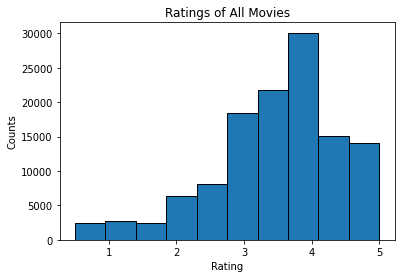

In [ ]:
plt.hist(data['Rating'], edgecolor="black", bins=10)
plt.xlabel("Rating")
plt.ylabel("Counts")
plt.title("Ratings of All Movies")

All ratings of the ten most popular movies (movies which have received the most ratings).

Text(0.5, 1.0, 'Ratings of Top Ten Most Popular Movies')

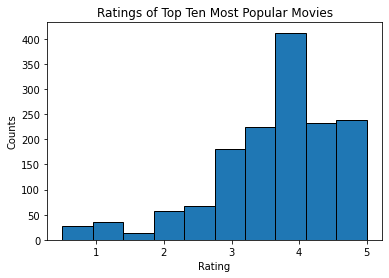

In [ ]:
df = data.sort_values(by=['Rating'], ascending=False)
top_ten_ratings = df[:10]['Movie ID'].values

df = data.loc[data['Movie ID'].isin(top_ten_ratings), :]
plt.hist(df['Rating'], edgecolor="black", bins=10)

plt.xlabel("Rating")
plt.ylabel("Counts")
plt.title("Ratings of Top Ten Most Popular Movies")

All ratings of the ten best movies (movies with the highest average ratings).

Text(0.5, 1.0, 'Ratings of Top Ten Best Movies')

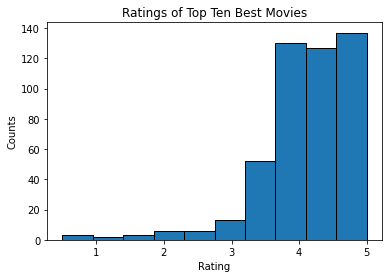

In [ ]:
all_movies = data['Movie ID'].unique()
averages = {}
for id in all_movies:
  averages[np.mean((data.loc[data['Movie ID'] == id, :])['Rating'].values)] = id
sorted_averages = sorted(averages, reverse=True)[:10]
top_ten_averages = []
for avg in sorted_averages:
  top_ten_averages.append(averages[avg])

df = data.loc[data['Movie ID'].isin(top_ten_averages), :]
plt.hist(df['Rating'], edgecolor="black", bins=10)

plt.xlabel("Rating")
plt.ylabel("Counts")
plt.title("Ratings of Top Ten Best Movies")

All ratings of movies from three genres of your choice (create three separate visualizations).

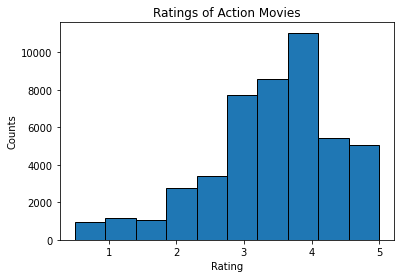

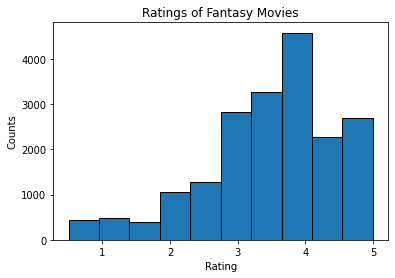

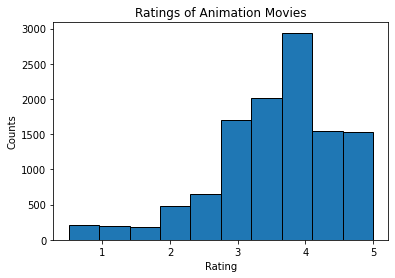

In [ ]:
favorite_genres = ['Action', 'Fantasy', 'Animation']
for genre in favorite_genres:
  ids = movie.loc[movie[genre] == 1]['Movie ID'].values
  df = data.loc[data['Movie ID'].isin(ids), :]
  plt.hist(df['Rating'], edgecolor="black", bins=10)
  plt.xlabel("Rating")
  plt.ylabel("Counts")
  plt.title("Ratings of " + genre + " Movies")
  plt.show()

## Matrix Factorization Visualizations:


In [ ]:
split = 12150
data_test = data.sample(split)
data_train = data.drop(data_test.index)

users = data_train['User ID'].unique()
movies =  data_train['Movie ID'].unique()
Y_train = []
Y_test = []

for _, row in data_train.iterrows():
  Y_train.append((row['User ID'], row['Movie ID'], row['Rating']))

for _, row in data_test.iterrows():
  Y_test.append((row['User ID'], row['Movie ID'], row['Rating']))

Y_train = np.array(Y_train).astype(int)
Y_test = np.array(Y_test).astype(int)

favorite_genres = ['Action', 'Fantasy', 'Animation']
ten_random_movies = random.sample(list(movies), 10)
ten_random_movies_genres = []
for genre in favorite_genres:
  ten_random_movies_genres.append(random.sample(list(movie.loc[movie[genre] == 1]['Movie ID'].values), 10))

### **Matrix Factorization Without Bias**

In [ ]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - np.dot(Ui, Vj)))

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - np.dot(Ui, Vj)))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = reg/2.0 * (np.linalg.norm(U, ord = 'fro')**2 + np.linalg.norm(V, ord = 'fro')**2)
    for i, j, Yij in Y:
      err += 0.5*(Yij-np.dot(U[i], V[j]))**2
    return err / len(Y)

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    losses = [get_err(U, V, Y, reg)]
    for e in range(max_epochs):
      shuffle = np.random.permutation(len(Y))
      for s in shuffle:
        i, j, Yij = Y[s]
        U[i] -= grad_U(U[i], Yij, V[j], reg, eta)
        V[j] -= grad_V(V[j], Yij, U[i], reg, eta)
      losses.append(get_err(U, V, Y, reg))
      print("Epoch " + str(e + 1) + ": E_in = " + str(losses[e]))
      if (losses[e] - losses[e + 1])/(losses[0] - losses[1]) <= eps:
        break
    return U, V, losses[len(losses) - 1]

In [ ]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

K = 20
reg = 0.0
eta = 0.03 # learning rate

# Use to compute Ein and Eout
U, V, err = train_model(M, N, K, eta, reg, Y_train)
E_in = err
E_out = get_err(U, V, Y_test)
print("E_out = " + str(E_out))

Epoch 1: E_in = 6.246794540328808
Epoch 2: E_in = 0.4532788939761653
Epoch 3: E_in = 0.3558618880767925
Epoch 4: E_in = 0.32238477683023
Epoch 5: E_in = 0.2987153854767736
Epoch 6: E_in = 0.2773001665043057
Epoch 7: E_in = 0.26718852013610606
Epoch 8: E_in = 0.2566907355169502
Epoch 9: E_in = 0.2503300319961662
Epoch 10: E_in = 0.24399309971757352
Epoch 11: E_in = 0.23792465012494357
Epoch 12: E_in = 0.2351217720600525
E_out = 0.5846591128964387


In [ ]:
A, Sigma, B = np.linalg.svd(np.transpose(V))
V_tilde = np.transpose(np.dot(V, A[:, :2]))
U_tilde = np.transpose(np.dot(U, A[:, :2]))

for V_row in range(len(V_tilde)):
  V_tilde[V_row] -= np.mean(V_tilde[V_row])
  U_tilde[V_row] -= np.mean(U_tilde[V_row])
  V_tilde[V_row] /= np.var(V_tilde[V_row])
  U_tilde[V_row] /= np.var(U_tilde[V_row])

Text(0.5, 1.0, 'Ten Random Movies (Without Bias)')

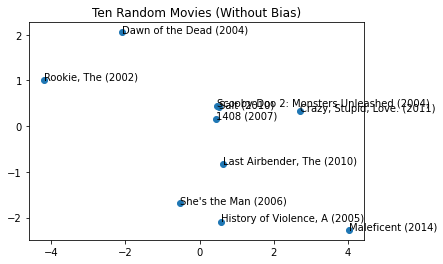

In [ ]:
labels = movie.iloc[ten_random_movies]['Movie Title'].values
plt.scatter(V_tilde[:, ten_random_movies][0], V_tilde[:, ten_random_movies][1])

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde[:, ten_random_movies][0][l], V_tilde[:, ten_random_movies][1][l]))

plt.title("Ten Random Movies (Without Bias)")

Text(0.5, 1.0, 'Ten Movies with Best Single Rating (Without Bias)')

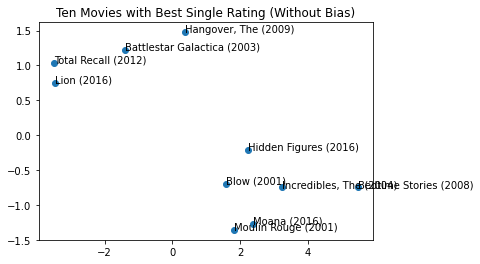

In [ ]:
labels = movie.iloc[top_ten_ratings]['Movie Title'].values
plt.scatter(V_tilde[:, top_ten_ratings][0], V_tilde[:, top_ten_ratings][1])

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde[:, top_ten_ratings][0][l], V_tilde[:, top_ten_ratings][1][l]))

plt.title("Ten Movies with Best Single Rating (Without Bias)")

Text(0.5, 1.0, 'Ten Movies with Best Average Rating (Without Bias)')

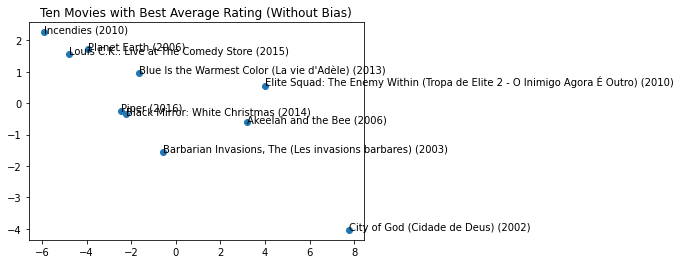

In [ ]:
labels = movie.iloc[top_ten_averages]['Movie Title'].values
plt.scatter(V_tilde[:, top_ten_averages][0], V_tilde[:, top_ten_averages][1])

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde[:, top_ten_averages][0][l], V_tilde[:, top_ten_averages][1][l]))

plt.title("Ten Movies with Best Average Rating (Without Bias)")

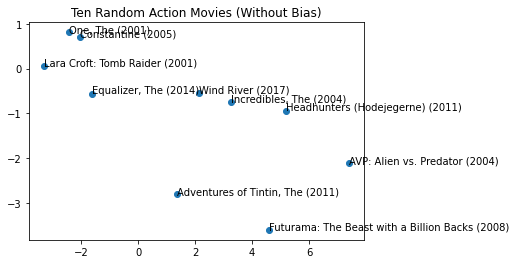

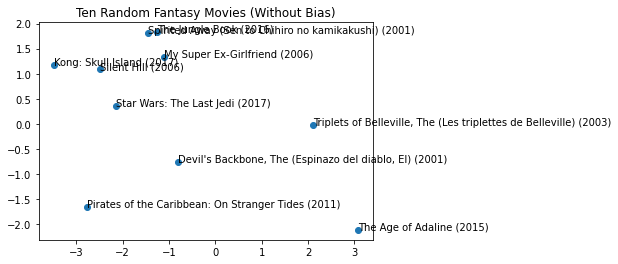

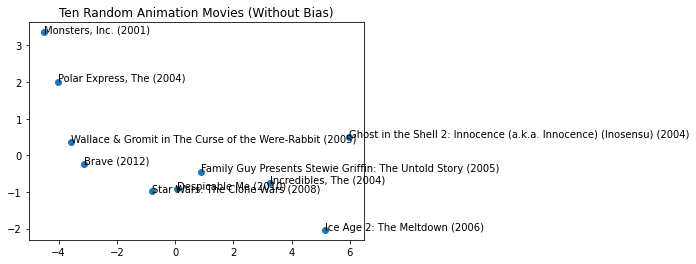

In [ ]:
for g in range(len(favorite_genres)):
  labels = movie.iloc[ten_random_movies_genres[g]]['Movie Title'].values
  plt.scatter(V_tilde[:, ten_random_movies_genres[g]][0], V_tilde[:, ten_random_movies_genres[g]][1])

  for l in range(len(labels)):
    plt.annotate(labels[l], (V_tilde[:, ten_random_movies_genres[g]][0][l], V_tilde[:, ten_random_movies_genres[g]][1][l]))

  plt.title("Ten Random " + favorite_genres[g] + " Movies (Without Bias)")
  plt.show()

### **Matrix Factorization With Bias**

In [ ]:
def grad_U_bias(Ui, Yij, Vj, ai, bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - np.dot(Ui, Vj) - ai - bj))

def grad_V_bias(Vj, Yij, Ui, ai, bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - np.dot(Ui, Vj) - ai - bj))

def grad_bias (Ui, Vj, Yij, ai, bj, eta):
    """
    Returns the gradient of the regularized loss function with
    respect to the bias terms multiplied by eta.
    """
    return -eta * (Yij - np.dot(Ui, Vj) - ai - bj)

def get_err_bias(U, V, a, b, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = reg/2.0 * (np.linalg.norm(U, ord = 'fro')**2 + np.linalg.norm(V, ord = 'fro')**2)
    for i, j, Yij in Y:
      err += 0.5*(Yij-np.dot(U[i], V[j]) - a[i] - b[j])**2
    return err / len(Y)

def train_model_bias(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    a = np.random.uniform(-0.5, 0.5, M)
    b = np.random.uniform(-0.5, 0.5, N)
    losses = [get_err_bias(U, V, a, b, Y, reg)]
    for e in range(max_epochs):
      shuffle = np.random.permutation(len(Y))
      for s in shuffle:
        i, j, Yij = Y[s]
        U[i] -= grad_U_bias(U[i], Yij, V[j], a[i], b[j], reg, eta)
        V[j] -= grad_V_bias(V[j], Yij, U[i], a[i], b[j], reg, eta)
        bias_update = grad_bias(U[i], V[j], Yij, a[i], b[j], eta)
        a[i] -= bias_update
        b[j] -= bias_update
      losses.append(get_err_bias(U, V, a, b, Y, reg))
      print("Epoch " + str(e + 1) + ": E_in = " + str(losses[e]))
      if (losses[e] - losses[e + 1])/(losses[0] - losses[1]) <= eps:
        break
    return U, V, a, b, losses[len(losses) - 1]

In [ ]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

K = 20

reg = 0.0
eta = 0.03 # learning rate

# Use to compute Ein and Eout
U_bias, V_bias, a, b, err = train_model_bias(M, N, K, eta, reg, Y_train)
E_in = err
E_out = get_err_bias(U_bias, V_bias, a, b, Y_test)
print("E_out = " + str(E_out))

Epoch 1: E_in = 6.317725081071924
Epoch 2: E_in = 0.42725222599953744
Epoch 3: E_in = 0.3347029246390946
Epoch 4: E_in = 0.28827737996391495
Epoch 5: E_in = 0.25583940451165194
Epoch 6: E_in = 0.23394288439062602
Epoch 7: E_in = 0.21900315417813454
Epoch 8: E_in = 0.20752492563958025
Epoch 9: E_in = 0.19878114078773498
Epoch 10: E_in = 0.1918233355988944
Epoch 11: E_in = 0.18594986729172086
Epoch 12: E_in = 0.1811747482636596
Epoch 13: E_in = 0.1775556678377561
Epoch 14: E_in = 0.17452731728328072
Epoch 15: E_in = 0.17142213156585018
Epoch 16: E_in = 0.16981084219855758
Epoch 17: E_in = 0.1673130596535494
Epoch 18: E_in = 0.16612509096134287
Epoch 19: E_in = 0.16394044388888931
E_out = 0.5921285694523803


In [ ]:
A, Sigma, B = np.linalg.svd(np.transpose(V_bias))
V_tilde_bias = np.transpose(np.dot(V_bias, A[:, :2]))
U_tilde_bias = np.transpose(np.dot(U_bias, A[:, :2]))

for V_row in range(len(V_tilde)):
  V_tilde_bias[V_row] -= np.mean(V_tilde_bias[V_row])
  U_tilde_bias[V_row] -= np.mean(U_tilde_bias[V_row])
  V_tilde_bias[V_row] /= np.var(V_tilde_bias[V_row])
  U_tilde_bias[V_row] /= np.var(U_tilde_bias[V_row])

Text(0.5, 1.0, 'Ten Random Movies (With Bias)')

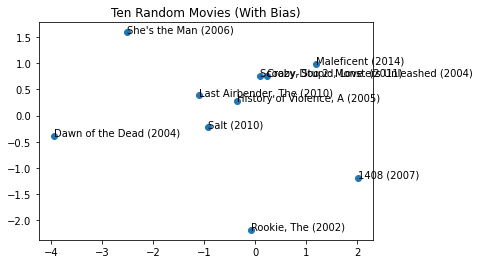

In [ ]:
labels = movie.iloc[ten_random_movies]['Movie Title'].values
plt.scatter(V_tilde_bias[:, ten_random_movies][0], V_tilde_bias[:, ten_random_movies][1])

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde_bias[:, ten_random_movies][0][l], V_tilde_bias[:, ten_random_movies][1][l]))

plt.title("Ten Random Movies (With Bias)")

Text(0.5, 1.0, 'Ten Movies with Best Single Rating (With Bias)')

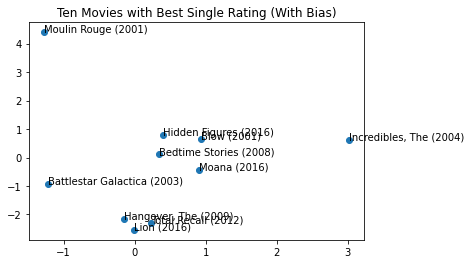

In [ ]:
labels = movie.iloc[top_ten_ratings]['Movie Title'].values
plt.scatter(V_tilde_bias[:, top_ten_ratings][0], V_tilde_bias[:, top_ten_ratings][1])

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde_bias[:, top_ten_ratings][0][l], V_tilde_bias[:, top_ten_ratings][1][l]))

plt.title("Ten Movies with Best Single Rating (With Bias)")

Text(0.5, 1.0, 'Ten Movies with Best Average Rating (With Bias)')

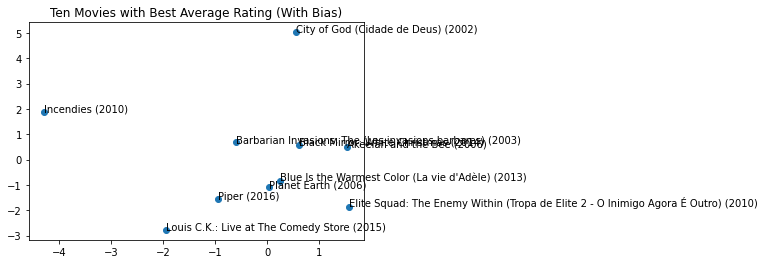

In [ ]:
labels = movie.iloc[top_ten_averages]['Movie Title'].values
plt.scatter(V_tilde_bias[:, top_ten_averages][0], V_tilde_bias[:, top_ten_averages][1])

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde_bias[:, top_ten_averages][0][l], V_tilde_bias[:, top_ten_averages][1][l]))

plt.title("Ten Movies with Best Average Rating (With Bias)")

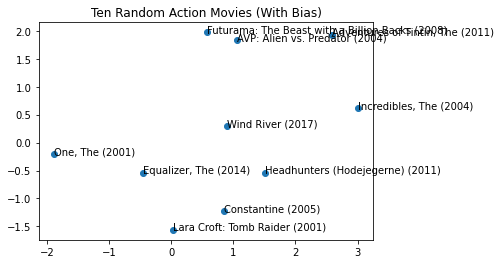

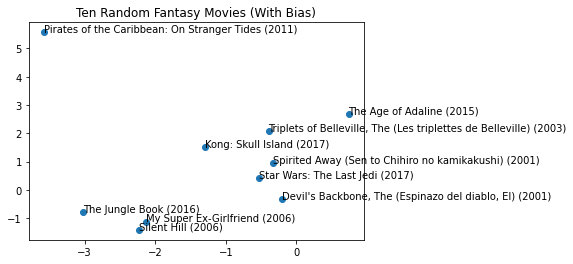

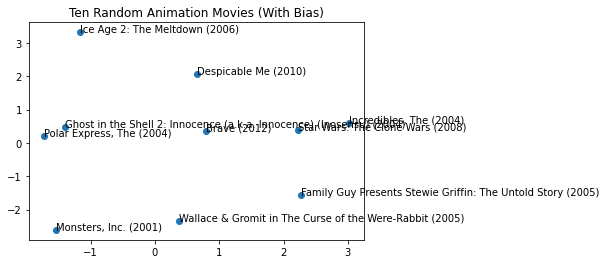

In [ ]:
for g in range(len(favorite_genres)):
  labels = movie.iloc[ten_random_movies_genres[g]]['Movie Title'].values
  plt.scatter(V_tilde_bias[:, ten_random_movies_genres[g]][0], V_tilde_bias[:, ten_random_movies_genres[g]][1])

  for l in range(len(labels)):
    plt.annotate(labels[l], (V_tilde_bias[:, ten_random_movies_genres[g]][0][l], V_tilde_bias[:, ten_random_movies_genres[g]][1][l]))

  plt.title("Ten Random " + favorite_genres[g] + " Movies (With Bias)")
  plt.show()

### **Matrix Factorization Using Off-the-Shelf**

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366609 sha256=ed6b62ee3d0c412232eedc577bd695f317775d79422704f752b0a027324588ae
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset, SVD, accuracy

In [ ]:
reader = Reader()
traindf = Dataset.load_from_df(data_train, reader)
trainset = traindf.build_full_trainset()
svd = SVD(n_factors = 20)
svd.fit(trainset)
V_off = svd.qi
U_off = svd.pu

In [ ]:
testdf = Dataset.load_from_df(data_test, reader)
testset = testdf.build_full_trainset()
print("Train:")
train = accuracy.rmse(svd.test(trainset.all_ratings()))
print("Test:")
test = accuracy.rmse(svd.test(testset.all_ratings()))

Train:
RMSE: 0.9971
Test:
RMSE: 1.2287


In [ ]:
A, Sigma, B = np.linalg.svd(np.transpose(V_off))
V_tilde_off = np.transpose(np.dot(V_off, A[:, :2]))
U_tilde_off = np.transpose(np.dot(U_off, A[:, :2]))

for V_row in range(len(V_tilde)):
  V_tilde_off[V_row] -= np.mean(V_tilde_off[V_row])
  U_tilde_off[V_row] -= np.mean(U_tilde_off[V_row])
  V_tilde_off[V_row] /= np.var(V_tilde_off[V_row])
  U_tilde_off[V_row] /= np.var(U_tilde_off[V_row])

Text(0.5, 1.0, 'Ten Random Movies (With Off-the-Shelf)')

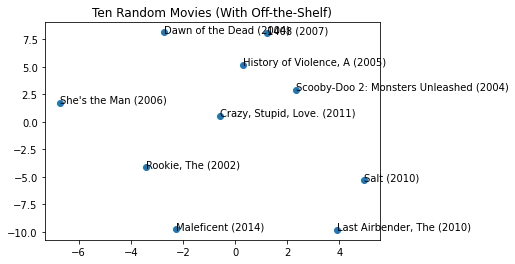

In [ ]:
labels = movie.iloc[ten_random_movies]['Movie Title'].values
plt.scatter(V_tilde_off[:, ten_random_movies][0], V_tilde_off[:, ten_random_movies][1])

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde_off[:, ten_random_movies][0][l], V_tilde_off[:, ten_random_movies][1][l]))

plt.title("Ten Random Movies (With Off-the-Shelf)")

Text(0.5, 1.0, 'Ten Movies with Best Single Rating (With Off-the-Shelf)')

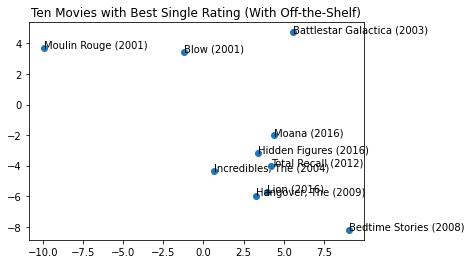

In [ ]:
labels = movie.iloc[top_ten_ratings]['Movie Title'].values
plt.scatter(V_tilde_off[:, top_ten_ratings][0], V_tilde_off[:, top_ten_ratings][1])

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde_off[:, top_ten_ratings][0][l], V_tilde_off[:, top_ten_ratings][1][l]))

plt.title("Ten Movies with Best Single Rating (With Off-the-Shelf)")

Text(0.5, 1.0, 'Ten Movies with Best Average Rating (With Off-the-Shelf)')

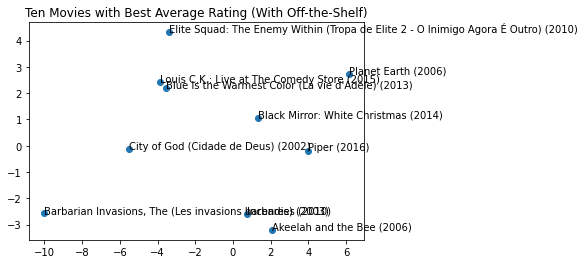

In [ ]:
labels = movie.iloc[top_ten_averages]['Movie Title'].values
plt.scatter(V_tilde_off[:, top_ten_averages][0], V_tilde_off[:, top_ten_averages][1])

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde_off[:, top_ten_averages][0][l], V_tilde_off[:, top_ten_averages][1][l]))

plt.title("Ten Movies with Best Average Rating (With Off-the-Shelf)")

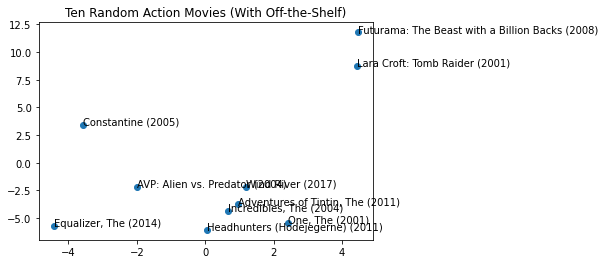

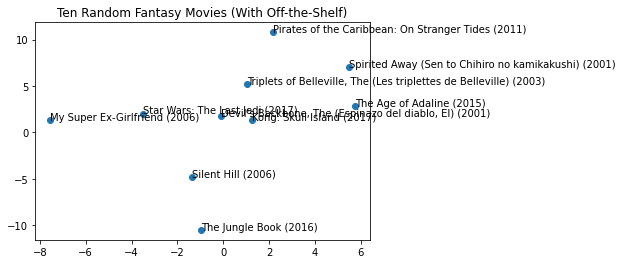

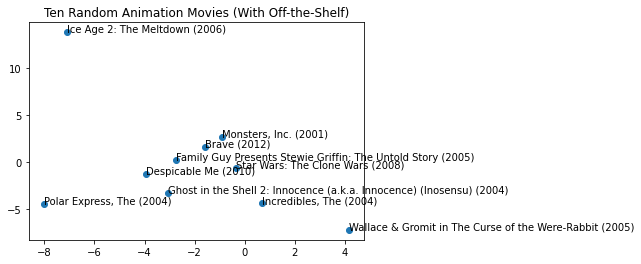

In [ ]:
for g in range(len(favorite_genres)):
  labels = movie.iloc[ten_random_movies_genres[g]]['Movie Title'].values
  plt.scatter(V_tilde_off[:, ten_random_movies_genres[g]][0], V_tilde_off[:, ten_random_movies_genres[g]][1])

  for l in range(len(labels)):
    plt.annotate(labels[l], (V_tilde_off[:, ten_random_movies_genres[g]][0][l], V_tilde_off[:, ten_random_movies_genres[g]][1][l]))

  plt.title("Ten Random " + favorite_genres[g] + " Movies (With Off-the-Shelf)")
  plt.show()

In [ ]:
M = (max(max(Y_train[:,0]), max(Y_test[:,0])) + 1).astype(int) # users
N = (max(max(Y_train[:,1]), max(Y_test[:,1])) + 1).astype(int) # movies

K = 20

reg = 0.0
eta = 0.03 # learning rate

# Use to compute Ein and Eout
U_spec, V_spec, a, b, err = train_model_bias(M, N, K, eta, reg, Y_train)

Epoch 1: E_in = 6.416760024009804
Epoch 2: E_in = 0.4259725219665763
Epoch 3: E_in = 0.332587691074969
Epoch 4: E_in = 0.2867338060607917
Epoch 5: E_in = 0.25507711864323535
Epoch 6: E_in = 0.23391598788340418
Epoch 7: E_in = 0.21839571344844902
Epoch 8: E_in = 0.2066475319735909
Epoch 9: E_in = 0.1983208032066967
Epoch 10: E_in = 0.19099996953699255
Epoch 11: E_in = 0.18554711844016328
Epoch 12: E_in = 0.181269047892037
Epoch 13: E_in = 0.17723663584124144
Epoch 14: E_in = 0.17438257546825747
Epoch 15: E_in = 0.1717306874204237
Epoch 16: E_in = 0.16929907835406902
Epoch 17: E_in = 0.16749871532682498


In [ ]:
A_s, Sigma_s, B_s = np.linalg.svd(np.transpose(V_spec))
V_tilde_spec = np.transpose(np.dot(V_spec, A_s[:, :2]))
U_tilde_spec = np.transpose(np.dot(U_spec, A_s[:, :2]))

for V_row in range(len(V_tilde_spec)):
  V_tilde_spec[V_row] -= np.mean(V_tilde_spec[V_row])
  U_tilde_spec[V_row] -= np.mean(U_tilde_spec[V_row])
  V_tilde_spec[V_row] /= np.var(V_tilde_spec[V_row])
  U_tilde_spec[V_row] /= np.var(U_tilde_spec[V_row])

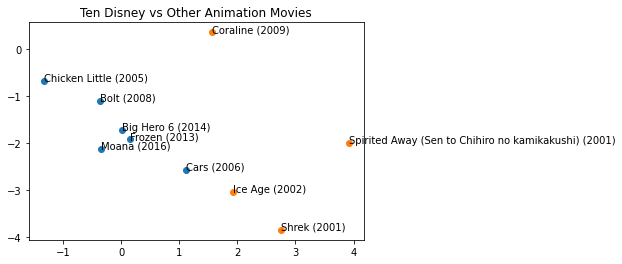

In [ ]:
specific_disney = [150, 175, 887, 225, 245, 472]
# Big Hero 6, Bolt, Moana, Cars, Chicken Little, Frozen

labels = movie.iloc[specific_disney]['Movie Title'].values
plt.scatter(V_tilde_spec[:, specific_disney][0], V_tilde_spec[:, specific_disney][1], c='#1f77b4')

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde_spec[:, specific_disney][0][l], V_tilde_spec[:, specific_disney][1][l]))

specific_notdisney = [1223, 627, 282, 1173]
# Spirited Away, Ice Age, Coraline, Shrek 

labels = movie.iloc[specific_notdisney]['Movie Title'].values
plt.scatter(V_tilde_spec[:, specific_notdisney][0], V_tilde_spec[:, specific_notdisney][1], c='#ff7f0e')

for l in range(len(labels)):
  plt.annotate(labels[l], (V_tilde_spec[:, specific_notdisney][0][l], V_tilde_spec[:, specific_notdisney][1][l]))


plt.title("Ten Disney vs Other Animation Movies")
plt.show()

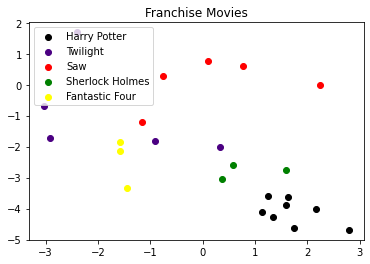

In [ ]:
specific_hp = [553, 554, 555, 556, 557, 558, 559, 560]

labels = movie.iloc[specific_hp]['Movie Title'].values
plt.scatter(V_tilde_spec[:, specific_hp][0], V_tilde_spec[:, specific_hp][1], c='black', label = 'Harry Potter')

specific_twilight = [1382, 1383, 1384, 1385, 1386]
labels = movie.iloc[specific_twilight]['Movie Title'].values
plt.scatter(V_tilde_spec[:, specific_twilight][0], V_tilde_spec[:, specific_twilight][1], c='indigo', label = 'Twilight')

specific_saw = [1119, 1120, 1121, 1122, 1123]
labels = movie.iloc[specific_saw]['Movie Title'].values
plt.scatter(V_tilde_spec[:, specific_saw][0], V_tilde_spec[:, specific_saw][1], c='red', label = 'Saw')

specific_sher = [1165, 1166, 1167]
labels = movie.iloc[specific_sher]['Movie Title'].values
plt.scatter(V_tilde_spec[:, specific_sher][0], V_tilde_spec[:, specific_sher][1], c='green', label = 'Sherlock Holmes')
  
specific_ff = [427, 428, 429]
labels = movie.iloc[specific_ff]['Movie Title'].values
plt.scatter(V_tilde_spec[:, specific_ff][0], V_tilde_spec[:, specific_ff][1], c='yellow', label = 'Fantastic Four')

plt.title("Franchise Movies")
plt.legend()
plt.show()

In [ ]:
all_movies = data['Movie ID'].unique()
averages = np.zeros(len(all_movies))
for id in all_movies:
  averages[id] = np.mean((data.loc[data['Movie ID'] == id, :])['Rating'].values)

raters = np.zeros(len(all_movies))
for id in all_movies:
  raters[id] = len(data.loc[data['Movie ID'] == id, :])

In [ ]:
print("Average Rating for Harry Potter Movies: " + str(np.mean(averages[specific_hp])))
print("Average Rating for Sherlock Holmes Movies: " + str(np.mean(averages[specific_sher])))
print("Average Rating for Saw Movies: " + str(np.mean(averages[specific_saw])))
print("Average Rating for Fantastic Four Movies: " + str(np.mean(averages[specific_ff])))
print("Average Rating for Twilight Movies: " + str(np.mean(averages[specific_twilight])))
print()
print("Average Number of Ratings for Harry Potter Movies: " + str(np.mean(raters[specific_hp])))
print("Average Number of Ratings for Sherlock Holmes Movies: " + str(np.mean(raters[specific_sher])))
print("Average Number of Ratings for Saw Movies: " + str(np.mean(raters[specific_saw])))
print("Average Number of Ratings for Fantastic Four Movies: " + str(np.mean(raters[specific_ff])))
print("Average Number of Ratings for Twilight Movies: " + str(np.mean(raters[specific_twilight])))

Average Rating for Harry Potter Movies: 3.6882571317789283
Average Rating for Sherlock Holmes Movies: 3.740494878176037
Average Rating for Saw Movies: 2.8849524428936197
Average Rating for Fantastic Four Movies: 2.7168867040012166
Average Rating for Twilight Movies: 2.634454690967296

Average Number of Ratings for Harry Potter Movies: 287.875
Average Number of Ratings for Sherlock Holmes Movies: 154.33333333333334
Average Number of Ratings for Saw Movies: 72.0
Average Number of Ratings for Fantastic Four Movies: 70.0
Average Number of Ratings for Twilight Movies: 51.6
